In [4]:
using Revise
using PrevisibilityCrawler
using StatsBase, XGBoost
pc = PrevisibilityCrawler;
Base.displaysize() = (30, 800)

In [31]:
using PrevisibilityCrawler
pc = PrevisibilityCrawler;

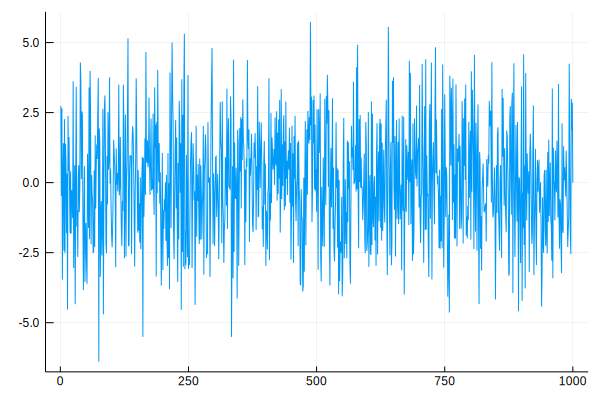

In [35]:
series = wn(1000)[:, 1]
plt.plot(series, legend=false)

In [13]:
function loadsimulation(paper, modellcallback)
    x, y, control, signal, xt, yt, controlt, signalout = loadfullpaperdata(paper, "boostpso");
    xp, yp = selectsig(x, y, signal)
    xtp, ytp = selectsig(xt, yt, signalout)
    wpipe = Pipeline(modellcallback(x, y), rmae)
    spipe = Pipeline(modellcallback(x, y), rmae)
    train!(wpipe, x, y)
    train!(spipe, xp, yp)
    wpred = Float64.(pc.predict(wpipe, xt))
    spred = Float64.(pc.predict(spipe, xtp));
    j = 1
    predsignal = fill(0., length(signalout))
    correct = fill(NaN, length(signalout))
    for i in 1:length(signalout)
        signalout[i] && (predsignal[i] = spred[j]; 
                         correct[i] = (spred[j]*yt[i]) > 0 ;j = j+1)
    end
    priceseries = Dict(paper=>controlt.lastPrice)
    datetimes = controlt.datetime
    wholepredictions = Dict(paper=>wpred)
    selpredictions = Dict(paper=>predsignal)
    return priceseries, datetimes, wholepredictions, selpredictions, correct

end

boostcallback(x, y) = boostgrid(x, y, nr_rounds=10)

boostcallback (generic function with 1 method)

In [14]:
boostdata = [loadsimulation(paper, boostcallback) for paper in papers];

In [26]:
function simulation(initialcash, priceseries, datetimes, wholepredictions, sellpredictions, correct)
    initialcash  = 100000.00
    wallet1 = holdportfolio(priceseries, datetimes, initialcash)
    wallet2 = corbystrategy(priceseries, datetimes, wholepredictions, initialcash);
    wallet3 = corbystrategy(priceseries, datetimes, sellpredictions, initialcash);
    trace1 = pty.scatter(x=wallet1.datetimes, y=wallet1.total, name="Stock")
    trace2 = pty.scatter(x=wallet2.datetimes, y=wallet2.total, name="Whole Model")
    trace3 = pty.scatter(x=wallet3.datetimes, y=wallet3.total, name="Selected Model")
    trace4 = pty.scatter(x=wallet3.datetimes, y=correct, name="correct")
    pty.plot([trace1, trace2, trace3, trace4])
end

simulation (generic function with 2 methods)

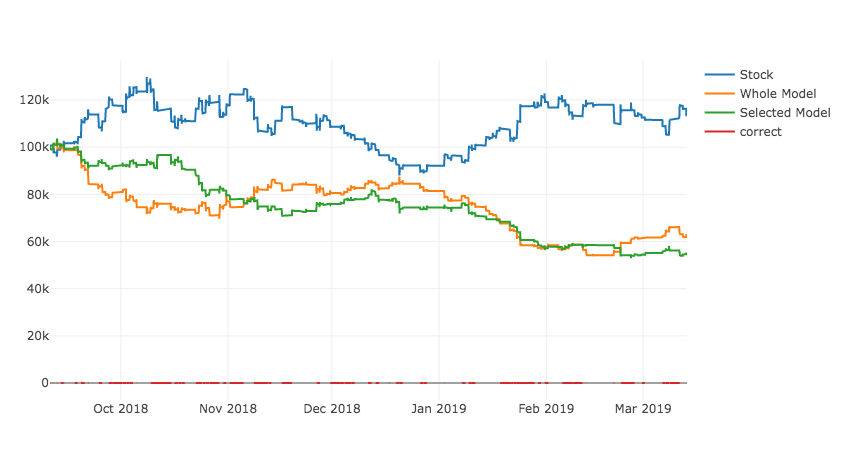

In [30]:
simulation(10000.00, boostdata[10]...)